In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

normalize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [3]:
test_path = './catdog_data/test'
train_path = './catdog_data/train'
validation_path = './catdog_data/validation'

train_data = ImageFolder(root = train_path, transform = train_transform)
test_data = ImageFolder(root = test_path, transform = normalize_transform)
validation_data = ImageFolder(root = validation_path, transform = normalize_transform)

In [ ]:
import pickle

class CNN(nn.Module):

    def __init__(self, activation_function):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 1)
        self.act1 = activation_function
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        self.act2 = activation_function
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.act3 = activation_function
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1)
        self.act4 = activation_function
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.act5 = activation_function
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.act2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.act3(self.conv3(x))
        x = self.maxpool3(x)
        x = self.act4(self.conv4(x))
        x = self.maxpool4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act5(self.fc1(x))
        x = self.fc2(x)
        return x

def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
    
    return running_loss / len(data_loader.dataset)

def validation(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = network(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return val_loss / len(data_loader.dataset), 100 * correct / total

results = []

batch_sizes = [128, 128, 256, 64, 64, 128, 256, 64, 128]
learning_rate = 0.001

activation_functions = {
    'ReLU - 128': nn.ReLU(),
    'Tanh - 128': nn.Tanh(),
    'Tanh - 256': nn.Tanh(),
    'LeakyReLU - 64': nn.LeakyReLU(),
    'ELU - 64': nn.ELU(),
    'ELU - 128': nn.ELU(),
    'ELU - 256': nn.ELU(),
    'SiLU - 64': nn.SiLU(),
    'SiLU - 128': nn.SiLU()
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50

indices_to_test = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for idx in range(0, len(batch_sizes)):
    act_name = list(activation_functions.keys())[idx]
    activation_function = list(activation_functions.values())[idx]
    batch_size = batch_sizes[idx]

    print(f"\n=== Testing {act_name} with batch size {batch_size} ===")

    activation_results = []

    train_dataloader = DataLoader(
        dataset = train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 2
    )

    validation_dataloader = DataLoader(
        dataset = validation_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 2
    )

    test_dataloader = DataLoader(
        dataset = test_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 2
    )

    model = CNN(activation_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = validation(model, validation_dataloader, criterion, device)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f} %")

    results.append({
        "index": idx,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "activation_function": act_name,
        "optimizer": "Adam",
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "val_accuracy_history": val_accuracy_history
    })

    activation_results.append({
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "optimizer": "Adam",
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "val_accuracy_history": val_accuracy_history
    })

    with open(f"select_cnn_experiments_{act_name}_{batch_size}.pkl", "wb") as f:
        pickle.dump(activation_results, f)
    
    print(f"\nResults saved for {act_name}-{batch_size}")

with open(f"select_cnn_experiments.pkl", "wb") as f:
    pickle.dump(results, f)

print("\nAll results saved")


=== Testing ReLU - 128 with batch size 128 ===
Epoch [1/50], Validation Loss: 0.6924, Validation Accuracy: 53.67 %
Epoch [2/50], Validation Loss: 0.6917, Validation Accuracy: 53.83 %
Epoch [3/50], Validation Loss: 0.6904, Validation Accuracy: 53.67 %
Epoch [4/50], Validation Loss: 0.6878, Validation Accuracy: 55.67 %
Epoch [5/50], Validation Loss: 0.6886, Validation Accuracy: 51.17 %
Epoch [6/50], Validation Loss: 0.6870, Validation Accuracy: 55.83 %
Epoch [7/50], Validation Loss: 0.6843, Validation Accuracy: 56.33 %
Epoch [8/50], Validation Loss: 0.6822, Validation Accuracy: 59.00 %
Epoch [9/50], Validation Loss: 0.6761, Validation Accuracy: 59.50 %
Epoch [10/50], Validation Loss: 0.6683, Validation Accuracy: 60.00 %
Epoch [11/50], Validation Loss: 0.6863, Validation Accuracy: 55.33 %
Epoch [12/50], Validation Loss: 0.6682, Validation Accuracy: 59.00 %
Epoch [13/50], Validation Loss: 0.6556, Validation Accuracy: 62.17 %
Epoch [14/50], Validation Loss: 0.6468, Validation Accuracy: 62.

In [ ]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd

with open("select_cnn_experiments_ReLU - 128_128.pkl", "rb") as f:
    results = pickle.load(f)

df_relu_128 = pd.DataFrame(results)

with open("select_cnn_experiments_Tanh - 128_128.pkl", "rb") as f:
    results = pickle.load(f)

df_tanh_128 = pd.DataFrame(results)

with open("select_cnn_experiments_Tanh - 256_256.pkl", "rb") as f:
    results = pickle.load(f)

df_tanh_256 = pd.DataFrame(results)

with open("select_cnn_experiments_LeakyReLU - 64_64.pkl", "rb") as f:
    results = pickle.load(f)

df_leakyrelu_64 = pd.DataFrame(results)

with open("select_cnn_experiments_ELU - 64_64.pkl", "rb") as f:
    results = pickle.load(f)

df_elu_64 = pd.DataFrame(results)

with open("select_cnn_experiments_ELU - 128_128.pkl", "rb") as f:
    results = pickle.load(f)

df_elu_128 = pd.DataFrame(results)

with open("select_cnn_experiments_ELU - 256_256.pkl", "rb") as f:
    results = pickle.load(f)

df_elu_256 = pd.DataFrame(results)

with open("select_cnn_experiments_SiLU - 64_64.pkl", "rb") as f:
    results = pickle.load(f)

df_silu_64 = pd.DataFrame(results)

with open("select_cnn_experiments_SiLU - 128_128.pkl", "rb") as f:
    results = pickle.load(f)

df_silu_128 = pd.DataFrame(results)

dfs = [df_relu_128, df_tanh_128, df_tanh_256, df_leakyrelu_64, df_elu_64, df_elu_128, df_elu_256, df_silu_64, df_silu_128]

plt.figure()
for i, df in dfs.iterrows():
    label = f"AF = {row['activation_function']}, BS = {row['batch_size']}"
    plt.plot(row['val_accuracy_history'], label = label)
plt.title("Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'iterrows'

<Figure size 640x480 with 0 Axes>

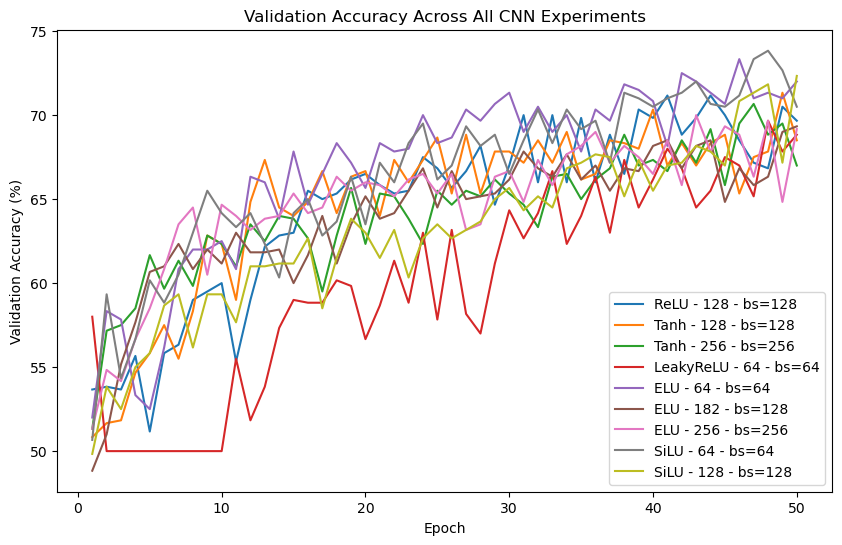

In [11]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd

with open("select_cnn_experiments.pkl", "rb") as f:
    all_results = pickle.load(f)

# Flatten if it's a list of lists
flat_results = []
for group in all_results:
    if isinstance(group, list):
        flat_results.extend(group)
    else:
        flat_results.append(group)

df_all = pd.DataFrame(flat_results)

plt.figure(figsize=(10, 6))

for _, row in df_all.iterrows():
    val_acc = row['val_accuracy_history']
    label = f"{row['activation_function']} - bs={row['batch_size']}"
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across All CNN Experiments")
plt.legend()
plt.show()